In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
def clean_text(text):
    #Removing unprintable characters
    text = ''.join(x for x in text if x.isprintable())

    # Cleaning the urls
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Cleaning the html elements
    text = re.sub(r'<.*?>', '', text)

    # Removing the punctuations
    text = re.sub('[!#?,.:";-@#$%^&*_~<>()-]', '', text)
    
    text = " ".join(word.lower() for word in text.split())
    return text

In [5]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [11]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [12]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

['../tokenizers/DL-raw-tokenizer-100.pk1']

In [13]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [14]:
vocab = tokenizer.word_index

In [15]:
start = process_time()
embedding_path = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix = get_embedding_matrix(embedding_path, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix.shape

51245
Total time taken:  4.974726505


(52576, 300)

In [16]:
input_dim = embedding_matrix.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  52576
Embedding dimensions:  300
Input sentence dimensions:  100


In [17]:
myCB = myCallbacks(metrics='acc', threshold=0.95)

# Feed-Forward Neural Network Model

In [16]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.0))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15772800  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 15,794,276
Trainable params: 21,476
Non-trainable params: 15,772,800
_________________________________________________________________


In [17]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 9s 7ms/step - loss: 0.7499 - acc: 0.7095 - val_loss: 0.6867 - val_acc: 0.7296
Epoch 2/8
1313/1313 [==============================] - 10s 7ms/step - loss: 0.6147 - acc: 0.7676 - val_loss: 0.6636 - val_acc: 0.7481
Epoch 3/8
1313/1313 [==============================] - 10s 7ms/step - loss: 0.5999 - acc: 0.7744 - val_loss: 0.6680 - val_acc: 0.7444
Epoch 4/8
1313/1313 [==============================] - 11s 8ms/step - loss: 0.5916 - acc: 0.7777 - val_loss: 0.6638 - val_acc: 0.7399
Epoch 5/8
1313/1313 [==============================] - 11s 9ms/step - loss: 0.5865 - acc: 0.7778 - val_loss: 0.6274 - val_acc: 0.7603
Epoch 6/8
1313/1313 [==============================] - 9s 6ms/step - loss: 0.5784 - acc: 0.7818 - val_loss: 0.6249 - val_acc: 0.7606
Epoch 7/8
1313/1313 [==============================] - 11s 9ms/step - loss: 0.5687 - acc: 0.7842 - val_loss: 0.6559 - val_acc: 0.7421
Epoch 8/8
1313/1313 [==============================] - 10s 8ms/s

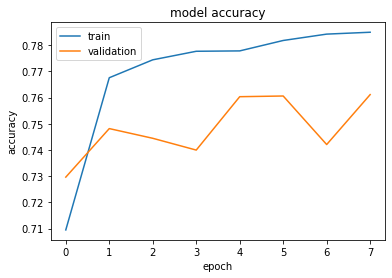

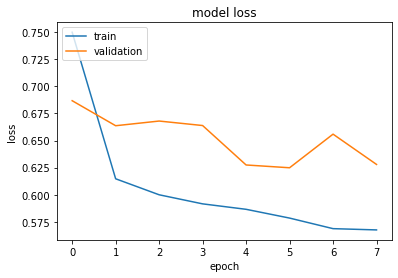

In [18]:
plot_curves(history1)

In [ ]:
name = "FFNN/FFNN-raw-n1.64-n2.32-kr0015-vacc7611"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-raw-n1.64-n2.32-kr0015-vacc7611.h5")

In [19]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [20]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.7611111111111111

Precision:  [0.68932039 0.83095578 0.78106509 0.68510259]
Average Precision:  0.7466109603858989

Recall:  [0.67619048 0.77408638 0.74576271 0.79175258]
Average Recall:  0.746948036028003

F1-Score:  [0.68269231 0.80151359 0.76300578 0.73457676]
Average F1-Score:  0.7454471083656766


# CNN Model

In [21]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix, 
                         input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.0))
myCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15772800  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 15,869,124
Trainable params: 96,324
Non-trainable params: 15,772,800
_________________________________________________________________


In [22]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val))

Epoch 1/8
1313/1313 [==============================] - 47s 36ms/step - loss: 0.4910 - acc: 0.8225 - val_loss: 0.3911 - val_acc: 0.8537
Epoch 2/8
1313/1313 [==============================] - 52s 39ms/step - loss: 0.3312 - acc: 0.8811 - val_loss: 0.3733 - val_acc: 0.8598
Epoch 3/8
1313/1313 [==============================] - 44s 34ms/step - loss: 0.2646 - acc: 0.9050 - val_loss: 0.3738 - val_acc: 0.8661
Epoch 4/8
1313/1313 [==============================] - 44s 34ms/step - loss: 0.2174 - acc: 0.9224 - val_loss: 0.3902 - val_acc: 0.8646
Epoch 5/8
1313/1313 [==============================] - 50s 38ms/step - loss: 0.1803 - acc: 0.9361 - val_loss: 0.4004 - val_acc: 0.8653
Epoch 6/8
1313/1313 [==============================] - 53s 40ms/step - loss: 0.1528 - acc: 0.9446 - val_loss: 0.4389 - val_acc: 0.8638
Epoch 7/8
1313/1313 [==============================] - 52s 40ms/step - loss: 0.1324 - acc: 0.9524 - val_loss: 0.4443 - val_acc: 0.8614
Epoch 8/8
1313/1313 [==============================] - 

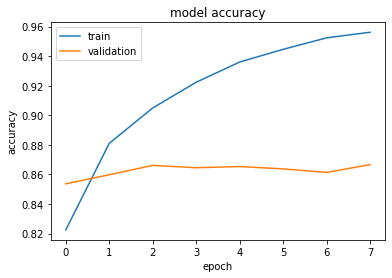

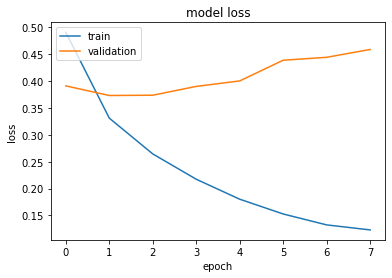

In [23]:
plot_curves(history2)

In [ ]:
name ="CNN/CNN-raw-n1.64n2.64-kr0015-vacc8666"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myCNN = model_load("../models/CNN/CNN-raw-n1.64n2.64-kr0015-vacc8666.h5")

In [24]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [25]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8666666666666667

Precision:  [0.83819629 0.86900958 0.88329519 0.85892116]
Average Precision:  0.8623555568676051

Recall:  [0.75238095 0.90365449 0.87231638 0.85360825]
Average Recall:  0.8454900172585644

F1-Score:  [0.79297365 0.88599349 0.87777146 0.85625646]
Average F1-Score:  0.8532487652199825


# Bi-LSTM Model

In [18]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix, 
                           input_len, 
                           trainable=False, 
                           n1=64, n2=64, 
                           d=0.3)
myLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15772800  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 128)          186880    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 15,968,196
Trainable params: 195,396
Non-trainable params: 15,772,800
_________________________________________________________________


In [19]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 234s 179ms/step - loss: 0.4598 - acc: 0.8292 - val_loss: 0.3592 - val_acc: 0.8730
Epoch 2/8
1313/1313 [==============================] - 214s 163ms/step - loss: 0.3590 - acc: 0.8689 - val_loss: 0.3347 - val_acc: 0.8825
Epoch 3/8
1313/1313 [==============================] - 226s 172ms/step - loss: 0.3207 - acc: 0.8816 - val_loss: 0.3276 - val_acc: 0.8854
Epoch 4/8
1313/1313 [==============================] - 243s 185ms/step - loss: 0.2910 - acc: 0.8921 - val_loss: 0.3323 - val_acc: 0.8810
Epoch 5/8
1313/1313 [==============================] - 252s 192ms/step - loss: 0.2684 - acc: 0.9023 - val_loss: 0.3163 - val_acc: 0.8865
Epoch 6/8
1313/1313 [==============================] - 255s 194ms/step - loss: 0.2478 - acc: 0.9087 - val_loss: 0.3070 - val_acc: 0.8902
Epoch 7/8
1313/1313 [==============================] - 326s 248ms/step - loss: 0.2319 - acc: 0.9137 - val_loss: 0.3366 - val_acc: 0.8870
Epoch 8/8
1313/1313 [====================

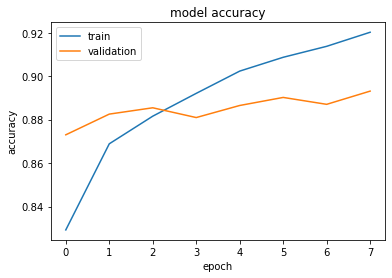

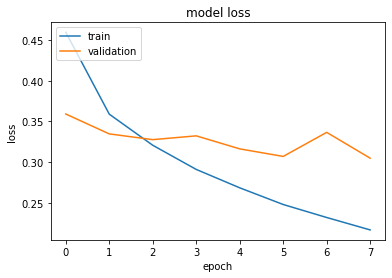

In [20]:
plot_curves(history3)

In [23]:
name= "LSTM/BiLSTM-raw-n1.64-n2.64-d30-vacc-8931"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myLSTM = model_load("../models/LSTM/BiLSTM-raw-n1.64-n2.64-d30-vacc-8931.h5")

In [21]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [22]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8931216931216931

Precision:  [0.86616162 0.90284204 0.90960452 0.87423935]
Average Precision:  0.8882118806347719

Recall:  [0.81666667 0.9076412  0.90960452 0.88865979]
Average Recall:  0.8806430440670999

F1-Score:  [0.84068627 0.90523526 0.90960452 0.88139059]
Average F1-Score:  0.8842291606166753
